In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from KSI_models import *
from KSI_utils import load_KSI_data, test_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = 'LSTM'
batch_size = 32
if model in ('LSTM', 'LSTMattn'):
    init_hidden = True

In [3]:
dir = 'data/original/'
loaders, wikivec, word_to_ix = load_KSI_data(dir=dir,
                                             batch_size=batch_size,
                                             train=False,
                                             val=False,
                                             test=True,
                                             device=DEVICE)
test_dataloader_orig = loaders['test']


In [4]:
base_model = torch.load(f'{dir}{model}_model.pt')
recall_at_k_1, micro_f1_1, macro_f1_1, micro_auc_1, macro_auc_1, label_aucs_1 = test_model(base_model,
                                                                                           test_dataloader_orig,
                                                                                           wikivec,
                                                                                           label_bins=f'{dir}bin_data.npy',
                                                                                           device=DEVICE,
                                                                                           init_hidden=init_hidden)
del base_model

ksi_model = torch.load(f'{dir}{model}_KSI_model.pt')
recall_at_k_2, micro_f1_2, macro_f1_2, micro_auc_2, macro_auc_2, label_aucs_2 = test_model(ksi_model,
                                                                                           test_dataloader_orig,
                                                                                           wikivec,
                                                                                           label_bins=f'{dir}bin_data.npy',
                                                                                           device=DEVICE,
                                                                                           init_hidden=init_hidden)
del ksi_model

In [5]:
dir = 'data/original_freqs/'
loaders, wikivec, word_to_ix = load_KSI_data(dir=dir,
                                             batch_size=batch_size,
                                             train=False,
                                             val=False,
                                             test=True,
                                             device=DEVICE)
test_dataloader_freqs = loaders['test']

In [6]:
mod_model = torch.load(f'{dir}{model}_ModifiedKSI_model.pt')
recall_at_k_3, micro_f1_3, macro_f1_3, micro_auc_3, macro_auc_3, label_aucs_3 = test_model(mod_model,
                                                                                           test_dataloader_freqs,
                                                                                           wikivec,
                                                                                           label_bins=f'{dir}bin_data.npy',
                                                                                           device=DEVICE,
                                                                                           init_hidden=init_hidden)
del mod_model

In [7]:
dir = 'data/original_tfidf/'
loaders, wikivec, word_to_ix = load_KSI_data(dir=dir,
                                             batch_size=batch_size,
                                             train=False,
                                             val=False,
                                             test=True,
                                             device=DEVICE)
test_dataloader_freqs = loaders['test']

In [8]:
tfidf_model = torch.load(f'{dir}{model}_ModifiedKSI_tfidf_model.pt')
recall_at_k_4, micro_f1_4, macro_f1_4, micro_auc_4, macro_auc_4, label_aucs_4 = test_model(tfidf_model,
                                                                                           test_dataloader_freqs,
                                                                                           wikivec,
                                                                                           label_bins=f'{dir}bin_data.npy',
                                                                                           device=DEVICE,
                                                                                           init_hidden=init_hidden)
del tfidf_model

In [9]:
label_aucs_1 = pd.DataFrame.from_dict(
    label_aucs_1,
    orient='index',
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_1['model'] = f'{model}'

label_aucs_2 = pd.DataFrame.from_dict(
    label_aucs_2,
    orient='index',
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_2['model'] = f'KSI+{model}'

label_aucs_3 = pd.DataFrame.from_dict(
    label_aucs_3,
    orient='index',
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_3['model'] = f'ModifiedKSI+{model}'

label_aucs_4 = pd.DataFrame.from_dict(
    label_aucs_4,
    orient='index',
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_4['model'] = f'ModifiedKSI+{model}, tfidf'

label_aucs = pd.concat([label_aucs_1,
                        label_aucs_2,
                        label_aucs_3,
                        label_aucs_4], axis=0)

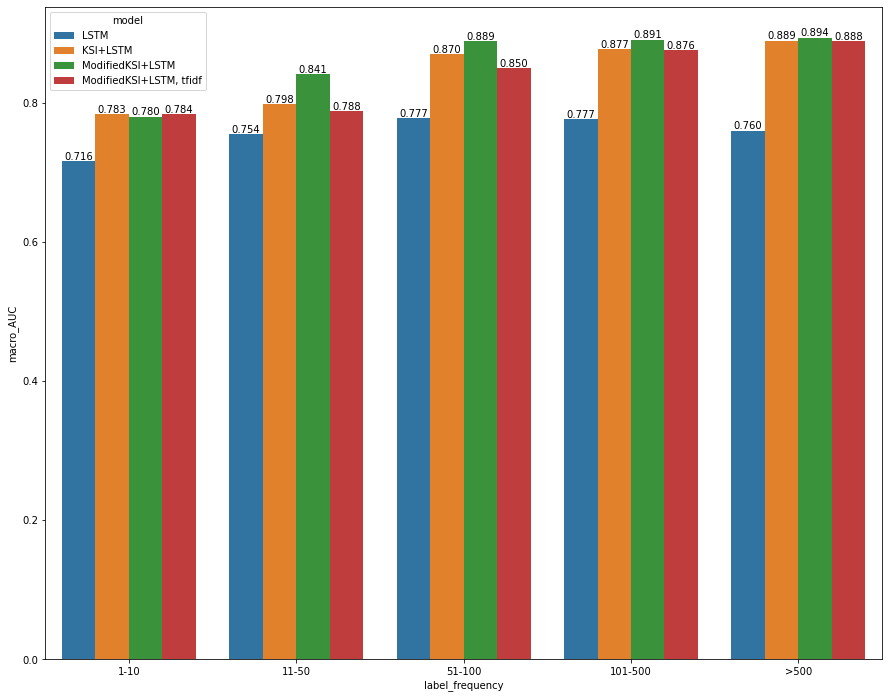

In [10]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='label_frequency', y='macro_AUC', hue='model',
                 data=label_aucs)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

In [11]:
metrics = {
    'model': [f'{model}', f'KSI+{model}', f'ModifiedKSI+{model}', f'ModifiedKSI+{model}, tfidf'],
    'recall_at_k': [recall_at_k_1, recall_at_k_2, recall_at_k_3, recall_at_k_4],
    'micro_f1': [micro_f1_1, micro_f1_2, micro_f1_3, micro_f1_4],
    'macro_f1': [macro_f1_1, macro_f1_2, macro_f1_3, macro_f1_4],
    'micro_auc': [micro_auc_1, micro_auc_2, micro_auc_3, micro_auc_4],
    'macro_auc': [macro_auc_1, macro_auc_2, macro_auc_3, macro_auc_4]
}
metrics = pd.DataFrame.from_dict(metrics)
metrics

,model,recall_at_k,micro_f1,macro_f1,micro_auc,macro_auc
0,LSTM,0.449636,0.357387,0.061061,0.889091,0.758929
1,KSI+LSTM,0.598082,0.461373,0.206924,0.941717,0.849191
2,ModifiedKSI+LSTM,0.643963,0.500605,0.230778,0.950497,0.865423
3,"ModifiedKSI+LSTM, tfidf",0.648877,0.503077,0.233821,0.947840,0.844559
